<a href="https://colab.research.google.com/github/rodgerrashan/fed-reasoning-cyber/blob/main/detectionModel/notebooks/AE_training_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Zero Day Attack detection

Library installation

In [1]:
!pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn wandb

Login to wandb and save your API key as a COLAB SECRET. https://wandb.ai/


In [2]:
import os
import wandb
from google.colab import userdata

wandb.login(userdata.get("WANDB_API_KEY"))

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: e20168 (e20168-university-of-peradeniya) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Setup libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


Ensure that your experiments are reproducible.

In [4]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Optional: For absolute precision with GPU operations
    # Note: This can slightly slow down training
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_all_seeds(42)

Connecting to T4 GPU

In [5]:
# Check if a GPU is available
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  print("GPU device not found. Check your runtime settings.")
else:
  print(f"Found GPU at: {device_name}")

# Alternative method to list physical devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPU device not found. Check your runtime settings.
Num GPUs Available:  0


Mounting G Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load CIC-IDS 2017 CSV Files

In [7]:
benign_filepath = "/content/drive/MyDrive/FYP/Data/UNSW NB15/UNSW_NB15_training-set.csv"

df = pd.read_csv(benign_filepath)
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [8]:
df.shape

(175341, 45)

In [9]:
# df.info()

#### PreProcessing

In [10]:
def clean_data(df):
  df = df.replace([np.inf, -np.inf], np.nan)
  df = df.dropna()
  return df

cleaned_df = clean_data(df)

# Strip white spapces in column names
cleaned_df.columns = cleaned_df.columns.str.strip()

cleaned_df.shape

(175341, 45)

Here label processign happens:

* BENIGN -> 0
* Attack -> 1

In [11]:
# cleaned_df.info()

In [12]:
# Drop unnecessary columns
df = cleaned_df.drop(['id', 'attack_cat'], axis=1)

# seperate labels
y = df['label']
X = df.drop(columns = ['label'])

According to the d.info, we have here several categorical column features such as 'proto', 'service', 'state'. So we have to perform one-hot encoding.

In [13]:
categorical_cols = ['proto', 'service', 'state']
numeric_cols = X.columns.difference(categorical_cols)

In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

X_cat = encoder.fit_transform(X[categorical_cols])
X_cat = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_cols))

X_num = X[numeric_cols]

### Feature Engineering

We have to get correlation matrix, just to identify what are the unwanted columns those are not directly go with attack.

/tmp/ipython-input-4261644636.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


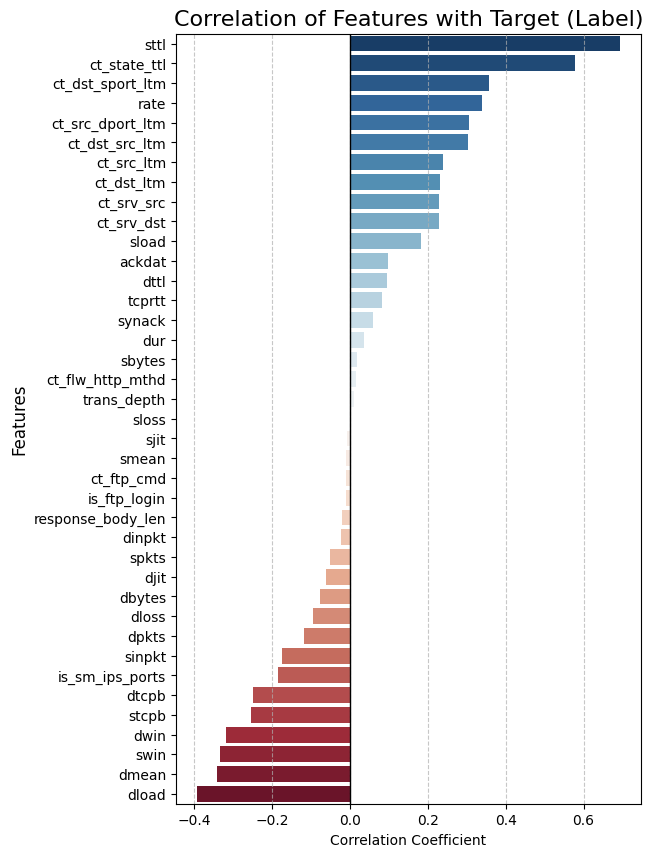

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Full data without cat data
full_data = X_num.copy()
full_data['label'] = y

target_corr = full_data.corr()['label'].drop('label').sort_values(ascending=False)

plt.figure(figsize=(6, 10))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    palette='RdBu_r'
)

plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.title("Correlation of Features with Target (Label)", fontsize=16)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [16]:
correlations = full_data.corr()['label'].drop('label').abs()

# threshold (e.g., 0.1 means 10% correlation)
threshold = 0.20

# Need Features
relevant_features = correlations[correlations > threshold].index

print(set(relevant_features))

# filtered DataFrame
X_num_filtered = X_num[relevant_features]

print(f"Original number of columns: {full_data.shape[1]}")
print(f"Columns kept after threshold: {len(relevant_features)}")
print(f"Dropped columns: {set(full_data.columns) - set(relevant_features)}")

{'swin', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_srv_dst', 'sttl', 'ct_src_ltm', 'ct_srv_src', 'ct_state_ttl', 'dload', 'dwin', 'dmean', 'ct_dst_ltm', 'rate', 'dtcpb', 'stcpb', 'ct_src_dport_ltm'}
Original number of columns: 40
Columns kept after threshold: 16
Dropped columns: {'spkts', 'dpkts', 'dinpkt', 'sjit', 'synack', 'sbytes', 'ackdat', 'is_sm_ips_ports', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'dbytes', 'is_ftp_login', 'label', 'trans_depth', 'sinpkt', 'dttl', 'smean', 'dur', 'response_body_len', 'dloss', 'sload', 'tcprtt', 'sloss', 'djit'}


In [17]:
X_processed = pd.concat([X_num_filtered, X_cat], axis=1)
X_processed.shape

(175341, 168)

We proposed to use Autoencoders for here. So AE should be trained only on normal traffic.

In [18]:
X_train = X_processed[y == 0]

X_test = X_processed # all data to test
y_test = y

Next, we have to do feature scaling.

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


#### Build AutoEncoder Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

input_dim = X_train_scaled.shape[1]

# --- Input Layer ---
input_layer = Input(shape=(input_dim,))

# --- Encoder Section ---
# ReLU is excellent for hidden layers as it avoids vanishing gradients
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded) # Bottleneck

# --- Decoder Section ---
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(128, activation='relu')(decoded)

# --- Output Layer ---
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, output_layer)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        21,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 168)            │        21,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,072 (250.28 KB)

 Trainable params: 64,072 (250.28 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training

Linking with wandb to visualize the training

In [21]:
import wandb

run = wandb.init(
    project="AE_training_FYP_Dawn",
    name="New_Dawn",
    notes="Loss function changed to Binary_crossentropy with MinMaxscaler",

    config={
        "batch_size": 64,
        "epochs": 100,
        "model": "AutoEncoder",
        "dataset": "UNSW-NB15",
        "patience": 5,
        "optimizer": "Adam",
        "threshold_percentile": 85,
        "loss":"binary_crossentropy",
    }
)


In [22]:
import wandb
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import recall_score, precision_score


class WandbAutoencoderLogger(Callback):
    def __init__(self, X_val, y_val, y_test, threshold_percentile):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.actual_labels = y_test
        self.threshold_percentile = threshold_percentile

    def on_epoch_end(self, epoch, logs=None):
      # 1. Get predictions
      # reconstructions = self.model.predict(self.X_val)

      # 2. Calculate reconstruction error (MSE)
      # mse = np.mean(np.power(self.X_val - reconstructions, 2), axis=1)


      # calculate threshold from threshold_percentile
      # threshold = np.percentile(mse, self.threshold_percentile)

      # y_pred = (mse > threshold).astype(int)

      # 4. Log to WandB
      wandb.log({
          "loss": logs['loss'],
          "val_loss": logs['val_loss']
      })

In [23]:

from tensorflow.keras.metrics import Precision, Recall

# Protect from overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=wandb.config.patience,
    restore_best_weights=True
)

# Make logs in WANDB Platform
wandb_logger = WandbAutoencoderLogger(
    X_val=X_test_scaled,
    y_val=X_test_scaled,
    y_test = y_test,
    threshold_percentile=wandb.config.threshold_percentile
)

autoencoder.compile(
    optimizer=wandb.config.optimizer,
    loss=wandb.config.loss,
    metrics=[Precision(), Recall()]
)

history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=run.config.epochs,
    batch_size=run.config.batch_size,
    validation_data=(X_test_scaled, X_test_scaled),
    callbacks=[early_stop, wandb_logger],
    verbose=1
)

run.finish()

Epoch 1/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1023 - precision: 0.6433 - recall: 0.2828 - val_loss: 0.0467 - val_precision: 0.9646 - val_recall: 0.3673
Epoch 2/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0186 - precision: 0.9987 - recall: 0.3487 - val_loss: 0.0504 - val_precision: 0.9678 - val_recall: 0.4330
Epoch 3/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0175 - precision: 0.9993 - recall: 0.3488 - val_loss: 0.0471 - val_precision: 0.9623 - val_recall: 0.4128
Epoch 4/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0172 - precision: 0.9994 - recall: 0.3502 - val_loss: 0.0493 - val_precision: 0.9659 - val_recall: 0.3770
Epoch 5/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0170 - precision: 0.9996 - recall: 0.3517 - val_loss: 0.0514 - val_precision: 0.9685 - val_recall: 0.4079
Epoch 6/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0169 - precision: 0.9997 - recall: 0.3516 - val_loss: 0.0528 - val_precision: 0.9683 - val_r

loss,█▁▁▁▁▁
val_loss,▁▅▁▄▆█
loss,0.0169
val_loss,0.05277


#### Detection logic and testing

In [24]:
# Calculate reconstruction error
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.square(X_test_scaled - reconstructions), axis=1)

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 4s 772us/step


In [25]:
from sklearn.metrics import f1_score, precision_recall_curve

# 1. Calculate Reconstruction Error (MSE per sample)
# Assuming autoencoder.predict returns the reconstructed X
X_test_pred = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

# 2. Use precision_recall_curve to find the best threshold automatically
precision, recall, thresholds = precision_recall_curve(y_test, mse)

# 3. Calculate F1 for every possible threshold
# F1 = 2 * (precision * recall) / (precision + recall)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10) # 1e-10 prevents div by zero

# 4. Find the best threshold
best_idx = np.argmax(f1_scores)
best_t = thresholds[best_idx]
# best_t = 0.006
max_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_t:.4f}")
print(f"Best F1-Score: {max_f1:.4f}")



5480/5480 ━━━━━━━━━━━━━━━━━━━━ 5s 861us/step
Best Threshold: 0.0001
Best F1-Score: 0.8383


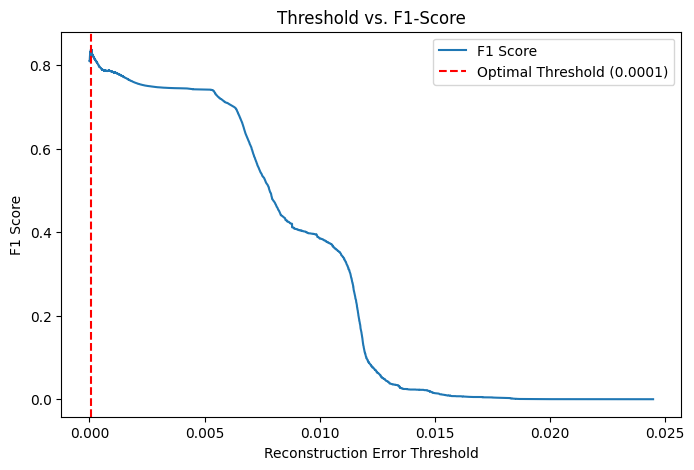

In [26]:

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(best_t, color='red', linestyle='--', label=f'Optimal Threshold ({best_t:.4f})')
plt.title("Threshold vs. F1-Score")
plt.xlabel("Reconstruction Error Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [27]:
y_pred = (mse > best_t).astype(int)

              precision    recall  f1-score   support

           0       0.80      0.27      0.40     56000
           1       0.74      0.97      0.84    119341

    accuracy                           0.75    175341
   macro avg       0.77      0.62      0.62    175341
weighted avg       0.76      0.75      0.70    175341

ROC-AUC: 0.8335676859946348


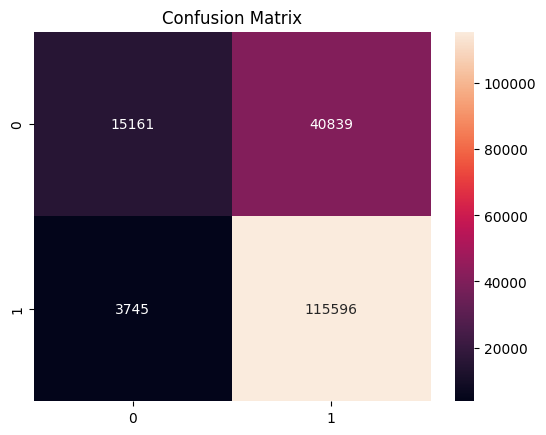

In [28]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, mse))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


### Save Model

In [29]:
import os
MODEL_DIR = "detectionModel"
os.makedirs(MODEL_DIR, exist_ok=True)

In [30]:
# save autoencoder
autoencoder.save(f"{MODEL_DIR}/autoencoder.keras")

# save scaler
import joblib
joblib.dump(scaler, f"{MODEL_DIR}/scaler.pkl")

# Save the encoder
joblib.dump(encoder, f"{MODEL_DIR}/encoder.pkl")

# save metadata
import json


metadata = {
    "numeric_columns": list(numeric_cols),
    "selected_numerical_columns": list(X_num_filtered.columns),
    "selected_categorical_columns: ": list(X_cat.columns),
    "categorical_columns": categorical_cols,
    "onehot_columns": list(X_cat.columns),
    "best_threshold": float(best_t)
}

with open(f"{MODEL_DIR}/metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

